## Is it a pop or hip-hop album?

In [1]:
!pip install -Uqq duckduckgo_search

## Step 1: Download images of album covers

In [1]:
from fastai.vision.all import *


/Users/adamomarali/opt/anaconda3/envs/ml/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/adamomarali/opt/anaconda3/envs/ml/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <9B280146-BBD7-3F77-9873-F9740F2A5329> /Users/adamomarali/opt/anaconda3/envs/ml/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <408F81C0-C6C8-33EF-B02E-B683F7178A71> /Users/adamomarali/opt/anaconda3/envs/ml/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
# from fastai.vision.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Search for hip hop album covers

In [10]:
urls = search_images('single hip hop album cover', max_images=1)
urls[0]

Searching for 'single hip hop album cover'


/Users/adamomarali/opt/anaconda3/envs/ml/lib/python3.10/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


'https://assets.capitalxtra.com/2013/48/best-hip-hop-album-covers-17-1386002951-view-0.jpg'

...and then download a URL and take a look at it:

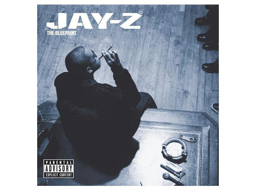

In [11]:
dest = 'hip hop.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'single pop album cover'


/Users/adamomarali/opt/anaconda3/envs/ml/lib/python3.10/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


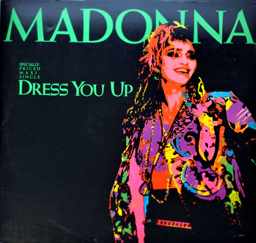

In [8]:
download_url(search_images('single pop album cover', max_images=1)[0], 'pop.jpg', show_progress=False)
Image.open('pop.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [13]:
searches = 'single pop album cover','single hip hop album cover'
path = Path('hip_hop_or_pop')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'single pop album cover photo'
Searching for 'single hip hop album cover photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [14]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

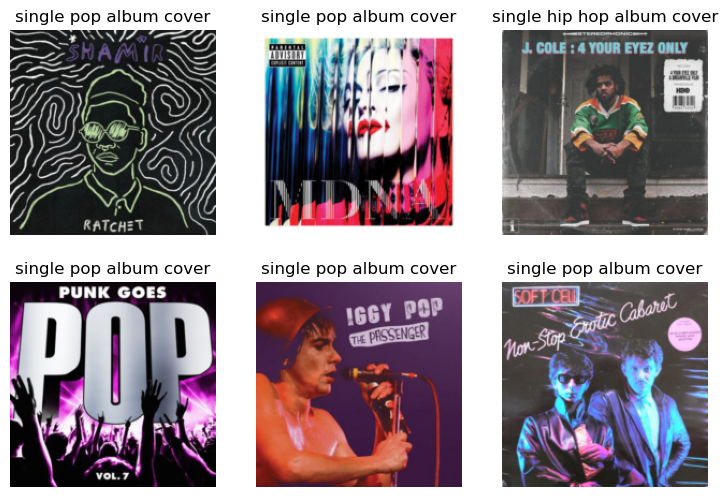

In [15]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=10)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [16]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/Users/adamomarali/opt/anaconda3/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/adamomarali/opt/anaconda3/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/adamomarali/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.216181,3.441504,0.545455,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.694794,2.692943,0.454545,00:03
1,0.571328,2.223327,0.545455,00:03
2,0.529143,1.811579,0.545455,00:03


## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [44]:
def predict(path):
    img = PILImage.create(path)
    is_hip_hop,_,probs = learn.predict(img)
    print(f"This is a: {is_hip_hop}.")
    print(f"Probability it's a hip hop album: {probs[0]:.4f}")


This is a: single hip hop album cover.
Probability it's a hip hop album: 0.9996
<PIL.Image.Image image mode=RGB size=256x243>


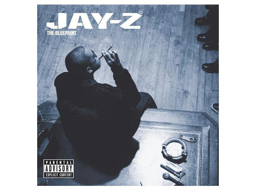

In [46]:
path = "hip hop.jpg"
predict(path)
Image.open(path).to_thumb(256,256)

This is a: single hip hop album cover.
Probability it's a hip hop album: 0.9998
<PIL.Image.Image image mode=RGB size=256x243>
label: single pop album cover


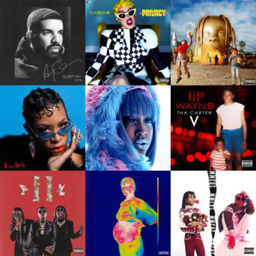

In [65]:
path = Path('hip_hop_or_pop')
img = 1
file = get_image_files(path)[img]
label = str(file).split("/")[1]
predict(file)
print("label:", label)
Image.open(file).to_thumb(256,256)

The model seems to have a lower accuracy than normal for a few reasons:
- Bad labelling like the example above (actually hip hop albums)
- The grid inputs will be biased to whether there are more grid images in the pop or hip hop folder
- Overall seems like darker colors contribute to the hip hop predictions